# Upper bound for $\|u_h\|_a$, where $u_h$ is the Galerkin Solution

Given any $v \in \mathbb{R}^m$, we define the set
$$
\mathcal{M}_v
:=
\Big\{
    \delta \in \mathbb{R}^m
    \, \Big| \,
    E(v + \delta) = E(v)
\Big\}
$$

Note that for any $d \in \mathbb{R}^m$, we have that
$$
\frac{2 r_v^\top d}{\| d \|_a^2} d \in \mathcal{M}_v.
$$

Especially, choosing $d = r_v$ we have
$$
\frac{2 \| r_v \|_2^2}{\| r_v \|_a^2} r_v \in \mathcal{M}_v.
$$

I the following, let
$$
\alpha(v, d) := \frac{2 r_v^\top d}{\| d \|_a^2}.
$$

## Idea 1: residual based iteration

$$
\begin{aligned}
    w_0 &:= v_n \\
    d_0 &:= r_{w_0}\\
    w_{j+1} &:= w_j + \alpha(w_j, r_j) r_j \\
    d_{j+1} &:= r_{w_{j+1}}
\end{aligned}
$$

Hypothesis:
$$
\|w_{j+1}\|_a \leq \|w_j\|_a
\, \Rightarrow \, \|u_h\|_a \leq \|w_j\|_a.
$$

### Experiment 1: random SPD matrix

In [47]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def random_sparse_spd(N, density=0.1):
    """
    Generate a random sparse symmetric positive definite (SPD) matrix of dimension N.
    
    Parameters:
    N (int): Dimension of the matrix.
    density (float): Approximate fraction of nonzero elements (default: 0.1).
    
    Returns:
    scipy.sparse.csr_matrix: A sparse SPD matrix.
    """
    # Generate a random sparse matrix
    A = sp.random(N, N, density=density, format='csr', data_rvs=np.random.randn) * 10
    
    # Make it symmetric
    A = (A + A.T) / 2
    
    # Ensure positive definiteness by adding N * I (diagonal dominance)
    A = A + N * sp.eye(N)
    
    return A

In [48]:
np.random.seed(40)

N = 1000  # Change as needed
sparse_spd_matrix = random_sparse_spd(N)

eigens, _ = spla.eigsh(sparse_spd_matrix, k=N-1)

right_hand_side = np.random.rand(N) * 0.1
galerkin_solution = spla.spsolve(sparse_spd_matrix, right_hand_side)

print(f'lambda max = {max(eigens)}')
print(f'lambda min = {min(eigens)}')

lambda max = 1140.6169022337774
lambda min = 859.2461347161068


In [49]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - sparse_spd_matrix.dot(current_iterate)

def get_alpha(current_iterate) -> float:
    residual = get_residual(current_iterate)
    two_norm_squared = residual.dot(residual)
    a_norm_squared = residual.dot(sparse_spd_matrix.dot(residual))
    return 2. * (two_norm_squared/a_norm_squared)

def get_next_iterate(current_iterate) -> np.ndarray:
    residual = get_residual(current_iterate)
    alpha = get_alpha(current_iterate)
    return current_iterate + alpha * residual

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(sparse_spd_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

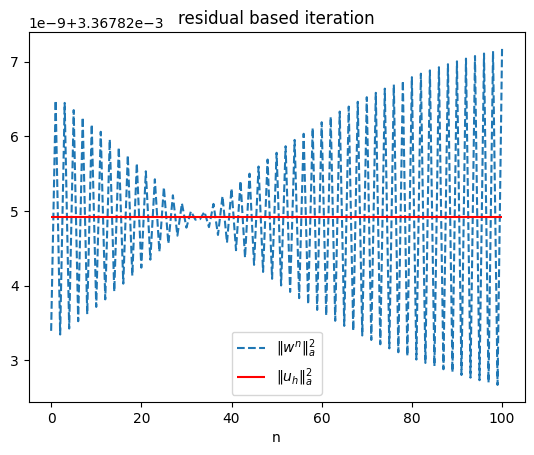

In [50]:
np.random.seed(41)

galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)

current_iterate = np.random.rand(N)

# Perform m Conjugate Gradient (CG) steps
m = 10  # Number of CG steps
current_iterate, _ = spla.cg(sparse_spd_matrix, right_hand_side, x0=current_iterate, maxiter=m)

last_energy = get_energy(current_iterate)
last_a_norm_squared = get_a_norm_squared(current_iterate)

energy_norm_history = [last_a_norm_squared]
potential_upper_bounds = []

maxiter = 100
for _ in range(maxiter):
    current_iterate = get_next_iterate(current_iterate)
    current_a_norm_squared = get_a_norm_squared(current_iterate)
    current_energy = get_energy(current_iterate)
    energy_norm_history.append(current_a_norm_squared)

    if not np.isclose(current_energy, last_energy):
        raise RuntimeError()
    
    gets_smaller = current_a_norm_squared < last_a_norm_squared
    if gets_smaller:
        potential_upper_bounds.append(last_a_norm_squared)

    last_a_norm_squared = current_a_norm_squared
    last_energy = current_energy

plt.plot(energy_norm_history, '--', label=r'$\|w^n\|_a^2$')
plt.xlabel('n')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=maxiter, color='red', label=r'$\|u_h\|_a^2$')
plt.title('residual based iteration')
plt.legend(loc='best')

The plot above can be interpreted in the following sense:
1. Recall that for the case of a random SPD matrix, the maximum and minimum eigenvalues are of same order of magnitude
2. The shape of $E = \text{const}.$ is expected to be spherical-like
3. The residual almost points into the centre of the sphere, i.e. intuitively we bounce back and forth

#### verification of upper bounds

In [24]:
potential_upper_bounds = np.array(potential_upper_bounds)
tightest_upper_bound = min(potential_upper_bounds)

print(f'all potential upper bounds ARE upper bounds: {np.all(galerkin_a_norm_squared <= potential_upper_bounds)}')
print(f'tightest upper bound         = {tightest_upper_bound}')
print(f'galerkin energy norm squared = {galerkin_a_norm_squared}')

all potential upper bounds ARE upper bounds: True
tightest upper bound         = 0.003367824988016928
galerkin energy norm squared = 0.0033678249114400807


### Experiment 2: L-shape Problem

In [51]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
import numpy as np
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [52]:
n_dofs = 8383
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [53]:
def get_residual(current_iterate) -> np.ndarray:
    Ax = stiffness_matrix.dot(current_iterate)
    residual = right_hand_side - Ax
    return residual

def get_alpha(current_iterate) -> float:
    residual = get_residual(current_iterate)
    two_norm_squared = residual.dot(residual)
    a_norm_squared = residual.dot(stiffness_matrix.dot(residual))
    return 2. * (two_norm_squared/a_norm_squared)

def get_next_iterate(current_iterate) -> np.ndarray:
    residual = get_residual(current_iterate)
    alpha = get_alpha(current_iterate)
    return current_iterate + alpha * residual

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

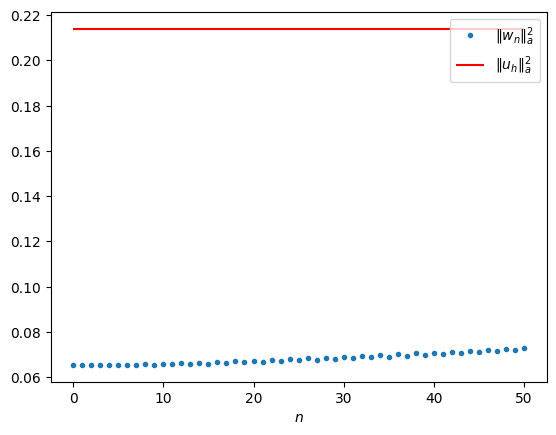

In [55]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)

current_iterate = np.zeros(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 5  # Number of CG steps
current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)

last_energy = get_energy(current_iterate)
last_a_norm_squared = get_a_norm_squared(current_iterate)

energy_norm_history = [last_a_norm_squared]
potential_upper_bounds = []

maxiter = 50
for _ in range(maxiter):
    current_iterate = get_next_iterate(current_iterate)
    current_a_norm_squared = get_a_norm_squared(current_iterate)
    current_energy = get_energy(current_iterate)
    energy_norm_history.append(current_a_norm_squared)

    if not np.isclose(current_energy, last_energy):
        raise RuntimeError()
    
    gets_smaller = current_a_norm_squared < last_a_norm_squared
    if gets_smaller:
        potential_upper_bounds.append(last_a_norm_squared)

    last_a_norm_squared = current_a_norm_squared
    last_energy = current_energy

plt.plot(energy_norm_history, '.', label=r'$\|w_n\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=maxiter, color='red', label=r'$\|u_h\|_a^2$')
plt.xlabel(r'$n$')
plt.legend(loc='best')

The plot above can be interpreted in the following sense:
1. For the SPD at hand, we have chosen the stiffness-matrix of an adaptively refined L-shape domain, i.e. we expect that the ratio of maximum and minimum eigenvalue is not as close to unity as was the case above.
2. The shape of $E = \text{const}.$ is expected to __not__ spherical-like
3. The residual does not point into the centre of the sphere, i.e. intuition from above breaks down.

In [25]:
potential_upper_bounds = np.array(potential_upper_bounds)

print(np.all(galerkin_a_norm_squared <= potential_upper_bounds))

tightest_upper_bound = min(potential_upper_bounds)

print(tightest_upper_bound)
print(galerkin_a_norm_squared)

False
0.06544505711259418
0.21392565195140623


## Idea 2: Looking into the directions $A e_i$ and $e_i$

Another idea is to consider the maximal positive spanning set of vectors
$\mathcal{B} := \{e_i, -e_i\}_{i=1}^m$.
Then, distort them with $A$, i.e. $A \mathcal{B}$.
Finally, from any $u_n$, you should (??? pure intuition + Satz des Thales in 2d) reach the other side with some $\widetilde{e}_i \in A \mathcal{B}$ on the same level set.

Let
$$
\begin{aligned}
    \mathcal{B}_m &:= \{e_1, \dots, e_m \}, \\
    A \mathcal{B}_m &:= \{A e_1, \dots, A e_m \}.
\end{aligned}
$$
Then, we postulate either
$$
\forall u_n \in \mathbb{R}^m
\, \exists \,
d \in \mathcal{B}
\, : \,
\|u_h\|_a \leq \|u_n + \alpha(u_n, d)d \|_a,
$$
or
$$
\forall u_n \in \mathbb{R}^m
\, \exists \,
d \in A \mathcal{B}
\, : \,
\|u_h\|_a \leq \|u_n + \alpha(u_n, d)d \|_a.
$$

In [2]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [3]:
n_dofs = 8383
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [4]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - stiffness_matrix.dot(current_iterate)

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

def get_alpha(current_iterate, direction) -> float:
    residual = get_residual(current_iterate)
    return 2. * residual.dot(direction) / get_a_norm_squared(direction)

In [16]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

current_iterate = np.zeros(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 100  # Number of CG steps

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)

potential_upper_bounds_distorted = []
potential_upper_bounds = []
energies = []
energies_distorted = []

for i in range(n_free_nodes):
    e_i = np.zeros(n_free_nodes)
    e_i[i] = 1

    Ae_i = stiffness_matrix.dot(e_i)
    alpha_i = get_alpha(current_iterate, Ae_i)
    shifted_iterate = current_iterate + alpha_i * Ae_i
    potential_upper_bounds_distorted.append(get_a_norm_squared(shifted_iterate))
    energies_distorted.append(get_energy(shifted_iterate))

    alpha_i = get_alpha(current_iterate, e_i)
    shifted_iterate = current_iterate + alpha_i * e_i
    potential_upper_bounds.append(get_a_norm_squared(shifted_iterate))
    energies.append(get_energy(shifted_iterate))

potential_upper_bounds_distorted = np.array(potential_upper_bounds_distorted)
potential_upper_bounds = np.array(potential_upper_bounds)

energies = np.array(energies)
energies_distorted = np.array(energies_distorted)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')
print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies_distorted)}')

sanity check, i.e. energies do not change: True
sanity check, i.e. energies do not change: True


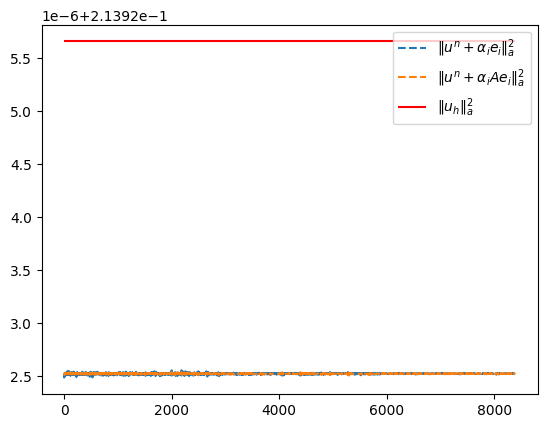

In [17]:
plt.plot(potential_upper_bounds, '--', label=r'$\|u^n + \alpha_i e_i\|_a^2$')
plt.plot(potential_upper_bounds_distorted, '--', label=r'$\|u^n + \alpha_i A e_i\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=n_dofs, color='red', label=r'$\|u_h\|_a^2$')
plt.legend(loc='best')

I think that the intuition from 2d complpetely breaks down for dimensions $d \gg 3$. I.e. the opening angle from any $u_n$ to the hyperplane's intersection point with the sphere / parabolloid becomes smaller and smaller. Hence, 

We fix some $w \in \mathbb{R}^m$.
Then, we consider the level set $\mathcal{M}_w$ s.t. $\forall \delta \in \mathcal{M}_w \,:\, E(w + \delta) = E(w)$.
Intuitively, it makes sense that $\exists \delta \in \mathcal{M}_w \,:\, \|u_h\|_a^2 \leq \|w + \delta\|_a^2$.
The question is, how do you algorithmically identify a suited $\delta \in \mathcal{M}_w$ efficiently?
Given a positive spanning set $\mathcal{B} := \{v_1, \dots, v_p\}$ and some $w \in \mathbb{R}^m$,
Thomas' suggestion is to scale all $v \in \mathcal{B}$ s.t. $\widetilde{v} \in \mathcal{M}_w$, i.e. $\widetilde{v} := \frac{2 r_w^\top v}{\|v\|_a^2} v$, where $r_w$ is the residual corresponding to $w$.
Then, we may (?) prove existence of $\delta \in \{\widetilde{v}_1, \dots, \widetilde{v}_p \}$ such that $b^\top (w + \delta - u) > 0 \Leftrightarrow \|u\|_a^2 < \|w + \delta\|_a^2 $.

### Idea 3: Bouncing inside the level set

In the following, for any $v \in \mathbb{R}^m$, let $H(v)$ the corresponding Householder reflector, i.e.
$$
H(v) := \left[ \text{Id} - 2 \frac{v v^\top}{\|v\|_2^2} \right].
$$
Then, we define the following iterative algorithm:

$$
\begin{aligned}
    w_0 &:= v_n \\
    d_0 &:= r_{w_0} \\
    w_{j+1} & := w_j + \alpha(w_j, d_j) d_j \\
    d_{j+1} & := H(r_{j+1}) r_j
\end{aligned}
$$

In [119]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [124]:
# n_dofs = 214738
n_dofs = 2945
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [125]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - stiffness_matrix.dot(current_iterate)

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

def get_alpha(current_iterate, direction) -> float:
    residual = get_residual(current_iterate)
    return 2. * residual.dot(direction) / get_a_norm_squared(direction)

def apply_householder(v: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w - 2. * (v.dot(w))/(v.dot(v)) * v

# __NOTE__: The code below is not doing what I thought it was doing!! Skip two cells to get the correct implementation

In [69]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

current_iterate = np.zeros(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 50  # Number of CG steps

a_norms_squared = []

energies = []

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)
current_residual = get_residual(current_iterate)
last_residual = current_residual
current_direction = current_residual

maxiter = 10*n_dofs
for _ in range(maxiter):

    # Euclidean updates
    current_iterate = current_iterate + get_alpha(current_iterate, current_direction) * current_direction
    current_residual = get_residual(current_iterate)
    current_direction = apply_householder(current_residual, last_residual)

    energies.append(get_energy(current_iterate))
    a_norms_squared.append(get_a_norm_squared(current_iterate))

    last_residual = current_residual

a_norms_squared = np.array(a_norms_squared)

energies = np.array(energies)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')

sanity check, i.e. energies do not change: True


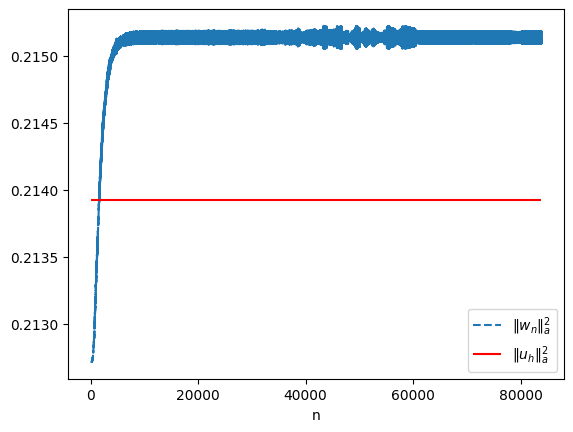

In [70]:
plt.plot(a_norms_squared, '--', label=r'$\|w_n\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=maxiter, color='red', label=r'$\|u_h\|_a^2$')
plt.xlabel('n')
plt.legend(loc='best')

In [217]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

np.random.seed(40)
current_iterate = np.random.rand(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 10  # Number of CG steps

a_norms_squared = []

energies = []

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)
current_residual = get_residual(current_iterate)
current_direction = current_residual

averaged_iterates = np.zeros(n_dofs)
maxiter = int(n_dofs/10)
for _ in range(maxiter):

    # Euclidean updates
    current_iterate = current_iterate + get_alpha(current_iterate, current_direction) * current_direction
    current_residual = get_residual(current_iterate)
    current_direction = apply_householder(current_residual, current_direction)

    energies.append(get_energy(current_iterate))
    a_norms_squared.append(get_a_norm_squared(current_iterate))

    averaged_iterates += current_iterate / maxiter

a_norms_squared = np.array(a_norms_squared)

mean_norm_squared = np.mean(a_norms_squared)

energies = np.array(energies)

energy_norm_squared_averaged_iterates = get_a_norm_squared(averaged_iterates)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')

sanity check, i.e. energies do not change: True


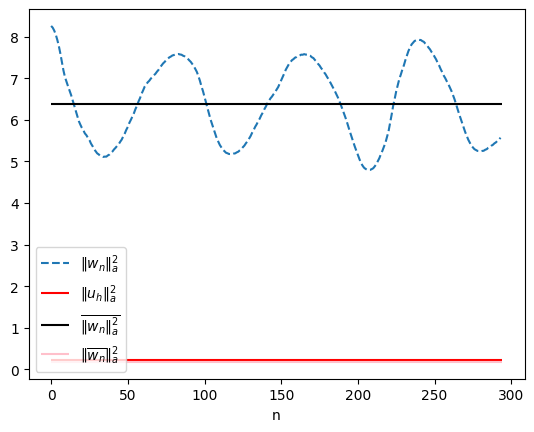

In [218]:
plt.plot(a_norms_squared, '--', label=r'$\|w_n\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=maxiter, color='red', label=r'$\|u_h\|_a^2$')
plt.hlines(y=mean_norm_squared, xmin=0, xmax=maxiter, color='black', label=r'$\overline{\|w_n\|_a^2}$')
plt.hlines(y=energy_norm_squared_averaged_iterates, xmin=0, xmax=maxiter, color='pink', label=r'$\|\overline{w_n}\|_a^2$')
plt.xlabel('n')
plt.legend(loc='best')

It looks interesting but I do not understand what is happening.

### Idea 3.5: bouncing inside the ellipsoid using different householder $H_A$

In [154]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [155]:
# n_dofs = 214738
n_dofs = 2945
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [168]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - stiffness_matrix.dot(current_iterate)

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

def get_alpha(current_iterate, direction) -> float:
    residual = get_residual(current_iterate)
    return 2. * residual.dot(direction) / get_a_norm_squared(direction)

def apply_householder_A(v: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w - 2. * (v.dot(stiffness_matrix.dot(w)))/(v.dot(stiffness_matrix.dot(v))) * v

def apply_householder(v: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w - 2. * (v.dot(w))/(v.dot(v)) * v

In [190]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

np.random.seed(49)
current_iterate = np.random.rand(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 5  # Number of CG steps

a_norms_squared = []

energies = []

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)
current_residual = get_residual(current_iterate)
last_residual = current_residual
current_direction = current_residual

maxiter = 100
for _ in range(maxiter):

    # Euclidean updates
    current_iterate = current_iterate + get_alpha(current_iterate, current_direction) * current_direction
    current_residual = get_residual(current_iterate)
    current_direction = apply_householder_A(current_residual, current_direction)

    energies.append(get_energy(current_iterate))
    a_norms_squared.append(get_a_norm_squared(current_iterate))

    last_residual = current_residual

a_norms_squared = np.array(a_norms_squared)

mean_norm_squared = np.mean(a_norms_squared)

energies = np.array(energies)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')

sanity check, i.e. energies do not change: True


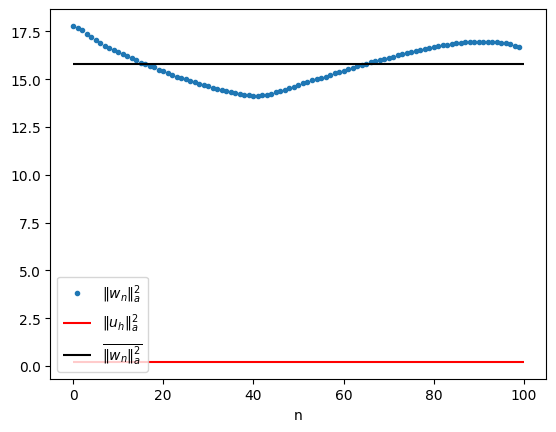

In [191]:
plt.plot(a_norms_squared, '.', label=r'$\|w_n\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=maxiter, color='red', label=r'$\|u_h\|_a^2$')
plt.hlines(y=mean_norm_squared, xmin=0, xmax=maxiter, color='black', label=r'$\overline{\|w_n\|_a^2}$')
plt.xlabel('n')
plt.legend(loc='best')

### Idea 4: Looking in random directions

In [31]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [44]:
n_dofs = 2945
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [45]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - stiffness_matrix.dot(current_iterate)

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

def get_alpha(current_iterate, direction) -> float:
    residual = get_residual(current_iterate)
    return 2. * residual.dot(direction) / get_a_norm_squared(direction)

In [48]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

current_iterate = np.zeros(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 10  # Number of CG steps

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)

energy_norm_squared_current_iterate = get_a_norm_squared(current_iterate)

residual = get_residual(current_iterate)
residual_norm = np.linalg.norm(residual)

potential_upper_bounds = []
energies = []

n_random_vectors = n_free_nodes
for i in range(n_random_vectors):
    random_direction = np.random.rand(n_free_nodes)
    random_direction_norm = np.linalg.norm(random_direction)

    direction = random_direction/random_direction_norm + residual/residual_norm
    
    alpha = get_alpha(current_iterate, direction)
    shifted_iterate = current_iterate + alpha * direction
    
    potential_upper_bounds.append(get_a_norm_squared(shifted_iterate))
    energies.append(get_energy(shifted_iterate))

potential_upper_bounds = np.array(potential_upper_bounds)
energies = np.array(energies)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')

sanity check, i.e. energies do not change: True


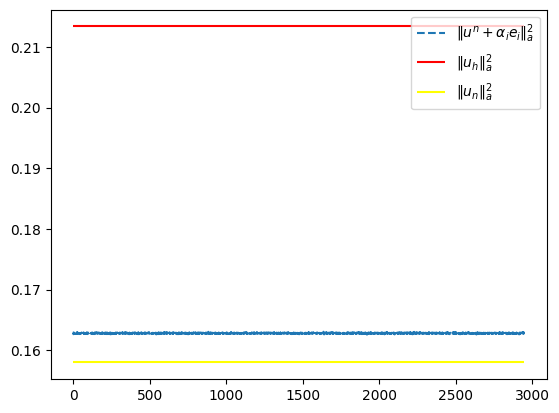

In [49]:
plt.plot(potential_upper_bounds, '--', label=r'$\|u^n + \alpha_i e_i\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=n_dofs, color='red', label=r'$\|u_h\|_a^2$')
plt.hlines(y=energy_norm_squared_current_iterate, xmin=0, xmax=n_dofs, color='yellow', label=r'$\|u_n\|_a^2$')
plt.legend(loc='best')

### Idea 5: rotating positive spanning set into orthogonal plane to residual and add residual

In [104]:
from load_save_dumps import load_dump
from pathlib import Path
from scipy.sparse import csr_matrix
from configuration import f, uD
from p1afempy.solvers import get_stiffness_matrix, get_right_hand_side, solve_laplace
from triangle_cubature.cubature_rule import CubatureRuleEnum
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [105]:
n_dofs = 2945
path_to_elements = Path(f'meshes/{n_dofs}/elements.pkl')
path_to_coordinates = Path(f'meshes/{n_dofs}/coordinates.pkl')
path_to_boundaries = Path(f'meshes/{n_dofs}/boundaries.pkl')

elements = load_dump(path_to_elements)
coordinates = load_dump(path_to_coordinates)
boundaries = load_dump(path_to_boundaries)

stiffness_matrix = csr_matrix(get_stiffness_matrix(
    coordinates=coordinates, elements=elements))
right_hand_side = get_right_hand_side(
    coordinates=coordinates,
    elements=elements,
    f=f,
    cubature_rule=CubatureRuleEnum.DAYTAYLOR)

n_vertices = coordinates.shape[0]
indices_of_free_nodes = np.setdiff1d(
    ar1=np.arange(n_vertices),
    ar2=np.unique(boundaries[0].flatten()))
free_nodes = np.zeros(n_vertices, dtype=bool)
free_nodes[indices_of_free_nodes] = 1
n_free_nodes = np.sum(free_nodes)

# reducing the full system to the free system once before continuing
stiffness_matrix = stiffness_matrix[free_nodes, :][:, free_nodes]
right_hand_side = right_hand_side[free_nodes]

galerkin_solution = spla.spsolve(stiffness_matrix, right_hand_side)

In [107]:
def get_residual(current_iterate) -> np.ndarray:
    return right_hand_side - stiffness_matrix.dot(current_iterate)

def get_a_norm_squared(current_iterate) -> float:
    return current_iterate.dot(stiffness_matrix.dot(current_iterate))

def get_energy(current_iterate) -> float:
    return 0.5 * get_a_norm_squared(current_iterate) - right_hand_side.dot(current_iterate)

def get_alpha(current_iterate, direction) -> float:
    residual = get_residual(current_iterate)
    return 2. * residual.dot(direction) / get_a_norm_squared(direction)

def get_householder_matrix(v: np.ndarray) -> np.ndarray:
    dim = v.shape[0]
    return np.identity(dim) - 2. * (np.outer(v, v))/np.linalg.norm(v)**2

def get_rotation(start: np.ndarray, end: np.ndarray):
    H1 = get_householder_matrix(end/np.linalg.norm(end) + start)
    H2 = get_householder_matrix(end)
    T = H2.dot(H1)
    return T

In [111]:
galerkin_a_norm_squared = get_a_norm_squared(galerkin_solution)
galerkin_energy = get_energy(galerkin_solution)

current_iterate = np.zeros(n_free_nodes)

# Perform m Conjugate Gradient (CG) steps
m = 10  # Number of CG steps

current_iterate, _ = spla.cg(
    stiffness_matrix,
    right_hand_side,
    x0=current_iterate,
    maxiter=m)

energy_norm_squared_current_iterate = get_a_norm_squared(current_iterate)

residual = get_residual(current_iterate)

potential_upper_bounds = []
energies = []

e_m = np.zeros(n_free_nodes)
e_m[-1] = 1

T = get_rotation(start=e_m, end=residual)

for i in range(n_free_nodes-1):
    e_i = np.zeros(n_free_nodes)
    e_i[i] = 1

    e_i_rotated = T.dot(e_i)

    direction = e_i_rotated*residual_norm + residual
    alpha = get_alpha(current_iterate, direction)
    shifted_iterate = current_iterate + alpha * direction
    
    potential_upper_bounds.append(get_a_norm_squared(shifted_iterate))
    energies.append(get_energy(shifted_iterate))

    direction = - e_i_rotated*residual_norm + residual
    alpha = get_alpha(current_iterate, direction)
    shifted_iterate = current_iterate + alpha * direction
    
    potential_upper_bounds.append(get_a_norm_squared(shifted_iterate))
    energies.append(get_energy(shifted_iterate))

potential_upper_bounds = np.array(potential_upper_bounds)
energies = np.array(energies)

print(f'sanity check, i.e. energies do not change: {np.allclose(get_energy(current_iterate), energies)}')

sanity check, i.e. energies do not change: True


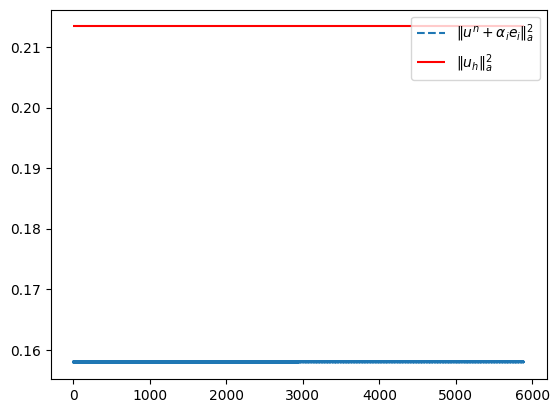

In [113]:
plt.plot(potential_upper_bounds, '--', label=r'$\|u^n + \alpha_i e_i\|_a^2$')
plt.hlines(y=galerkin_a_norm_squared, xmin=0, xmax=2*n_free_nodes, color='red', label=r'$\|u_h\|_a^2$')
plt.legend(loc='best')

## Solid Angle in arbitrary dimensions
_Source_: [wikipedia](https://en.wikipedia.org/wiki/Solid_angle#Solid_angles_in_arbitrary_dimensions)

In [20]:
import math

def full_solid_angle(dimension: int) -> float:
    if dimension % 2 == 0:
        numerator = 2.*(np.pi)**(dimension/2.)
        denominator = math.factorial(dimension/2 - 1)
        return numerator / denominator

/var/folders/l2/1nyhpf0159bc45_j9_qfp58r0000gn/T/ipykernel_53171/901239915.py:6: DeprecationWarning: Using factorial() with floats is deprecated
  denominator = math.factorial(dimension/2 - 1)


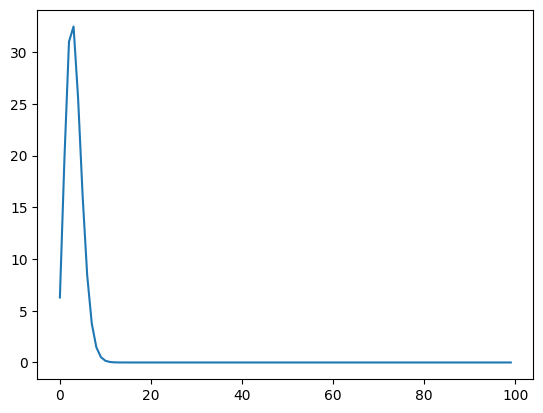

In [23]:
dimensions = 2*(np.arange(100)+1)

full_solid_angles = []
for dimension in dimensions:
    full_solid_angles.append(full_solid_angle(dimension=dimension))

plt.plot(full_solid_angles)